# 1. 환경 설정

`(1) Env 환경변수`

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

`(2) 기본 라이브러리`

In [2]:
import re
import os, json
from glob import glob

from textwrap import dedent
from pprint import pprint

import uuid

import warnings
warnings.filterwarnings("ignore")

In [3]:
from langchain_chroma import Chroma
from langchain_ollama  import OllamaEmbeddings
from langchain_core.documents import Document

from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import CrossEncoderReranker
from langchain_community.cross_encoders import HuggingFaceCrossEncoder
from langchain_community.retrievers import TavilySearchAPIRetriever
from langchain_core.tools import tool
from typing import List


In [4]:
os.getcwd()

'/Users/simsewon/Documents/agent_project/NaturalLangProcessingInBigData/notebook'

In [5]:
os.chdir('/Users/simsewon/Documents/agent_project/NaturalLangProcessingInBigData')

#  2. 도구 호출

###  법률 정보 검색 도구, 웹 검색 도구 정의

In [6]:

# 문서 임베딩 모델
embeddings_model = OllamaEmbeddings(model="bge-m3") 

# Re-rank 모델
rerank_model = HuggingFaceCrossEncoder(model_name="BAAI/bge-reranker-v2-m3")
cross_reranker = CrossEncoderReranker(model=rerank_model, top_n=2)



### 도로교통법 검색 


In [7]:
road_traffic_db = Chroma(
    embedding_function=embeddings_model,   
    collection_name="road_traffic_law",
    persist_directory="../chroma_db",
)

road_traffic_db_retriever = ContextualCompressionRetriever(
    base_compressor=cross_reranker, 
    base_retriever=road_traffic_db.as_retriever(search_kwargs={"k":5}),
)

@tool
def road_traffic_law_search(query: str) -> List[Document]:
    """도로교통법 법률 조항을 검색합니다."""
    docs = road_traffic_db_retriever.invoke(query)

    if len(docs) > 0:
        return docs
    
    return [Document(page_content="관련 정보를 찾을 수 없습니다.")]




### 전자상거래법 검색 


In [8]:
ecommerce_db = Chroma(
    embedding_function=embeddings_model,   
    collection_name="ecommerce_law_v2",
    persist_directory="../chroma_db",
)

ecommerce_db_retriever = ContextualCompressionRetriever(
    base_compressor=cross_reranker, 
    base_retriever=ecommerce_db.as_retriever(search_kwargs={"k":5}),
)


@tool
def ecommerce_law_search(query: str) -> List[Document]:
    """전자상거래_소비자보호 법률 조항을 검색합니다."""
    docs = ecommerce_db_retriever.invoke(query)

    if len(docs) > 0:
        return docs
    
    return [Document(page_content="관련 정보를 찾을 수 없습니다.")]




### 주택임대차보호법 검색 


In [9]:
housing_db = Chroma(
    embedding_function=embeddings_model,   
    collection_name="housing_law",
    persist_directory="../chroma_db",
)

housing_db_retriever = ContextualCompressionRetriever(
    base_compressor=cross_reranker, 
    base_retriever=housing_db.as_retriever(search_kwargs={"k":5}),
)



@tool
def housing_law_search(query: str) -> List[Document]:
    """주택임대차보호법 법률 조항을 검색합니다."""
    docs = housing_db_retriever.invoke(query)

    if len(docs) > 0:
        return docs
    
    return [Document(page_content="관련 정보를 찾을 수 없습니다.")]




### 웹 검색


In [10]:
web_retriever = ContextualCompressionRetriever(
    base_compressor=cross_reranker, 
    base_retriever=TavilySearchAPIRetriever(k=10),
)

@tool
def web_search(query: str) -> List[str]:
    """데이터베이스에 없는 정보 또는 최신 정보를 웹에서 검색합니다."""

    docs = web_retriever.invoke(query)

    formatted_docs = []
    for doc in docs:
        formatted_docs.append(
            Document(
                page_content= f'<Document href="{doc.metadata["source"]}"/>\n{doc.page_content}\n</Document>',
                metadata={"source": "web search", "url": doc.metadata["source"]}
            )
        )

    if len(formatted_docs) > 0:
        return formatted_docs
    
    return [Document(page_content="관련 정보를 찾을 수 없습니다.")]

In [11]:
# 도구 목록을 정의 
tools = [ecommerce_law_search, road_traffic_law_search, housing_law_search, web_search]

### LLM 모델 Tool Calling

In [12]:
# from langchain_openai import ChatOpenAI

# # LLM 
llm = ChatOpenAI(model="gpt-4.1", temperature=0, streaming=True)

# # LLM에 도구 바인딩하여 추가 
# llm_with_tools = llm.bind_tools(tools)

from langchain.agents import create_tool_calling_agent, AgentExecutor
from langchain.prompts import ChatPromptTemplate  # 혹은 SystemMessagePromptTemplate 등

# 프롬프트 예시 (시스템 프롬프트 역할)
from langchain.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages([
    ("system", "너는 법률 상담 전문가야. 사용자의 질문에 따라 적절한 도구를 반드시 사용해 답변해."),
    ("human", "{input}"),
    ("ai", "{agent_scratchpad}")  # 에이전트가 툴을 호출하거나 reasoning(중간 추론)할 때 쌓이는 기록
])


# 에이전트 생성 시 prompt 추가
agent = create_tool_calling_agent(llm, tools, prompt)
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)


In [ ]:
# 사용 예시
query = "전자제품은 개봉 시 환불이 안된다고 하는데, 물건이 불량이었을 때도 동일한가요?" #"중고거래를 했는데 물품을 전달받지 못했어요."
response = agent_executor.invoke({"input": query})

In [ ]:

# 사용 예시
query = "영업정지 대신 과징금 부여하는 기준을 알려주세요."
response = agent_executor.invoke({"input": query})

In [67]:
# 모호한 질문을 하는 경우 
query = "과징금 부여기준을 알려주세요."
response = agent_executor.invoke({"input": query})



> Entering new AgentExecutor chain...

Invoking: `web_search` with `{'query': '과징금 부여기준'}`


[Document(metadata={'source': 'web search', 'url': 'https://www.lawmaking.go.kr/lmKnlg/jdgStd/info?astSeq=2232'}, page_content='<Document href="https://www.lawmaking.go.kr/lmKnlg/jdgStd/info?astSeq=2232"/>\n자격 부여; 21. 외국인의 지위 ... 제21조(과징금 부과기준 등) ① 법 제27조에 따른 위반행위의 종류와 위반 정도에 따른 과징금의 금액은 별표 1과 같다. ② 시·도지사는 제1항에 따라 과징금을 부과하는 경우 위반행위의 정도, 위반횟수, 위반행위의 동기와 그\n</Document>'), Document(metadata={'source': 'web search', 'url': 'https://namu.wiki/w/과징금'}, page_content='<Document href="https://namu.wiki/w/과징금"/>\n제28조(과징금의 기준) ① 행정청은 법령등에 따른 의무를 위반한 자에 대하여 법률로 정하는 바에 따라 그 위반행위에 대한 제재로서 과징금을 부과할 수 있다. ② 과징금의 근거가 되는 법률에는 과징금에 관한 다음 각 호의 사항을 명확하게 규정하여야 한다. 1.\n</Document>')]과징금 부여기준은 일반적으로 다음과 같이 정해집니다.

1. 법적 근거
- 과징금은 각 법률(예: 공정거래법, 전자상거래법 등)에 따라 부과할 수 있으며, 해당 법률에 과징금의 부과 기준, 금액, 절차 등이 명확히 규정되어 있습니다.

2. 부과 기준
- 위반행위의 종류와 위반 정도에 따라 과징금의 금액이 달라집니다.
- 위반행위의 정도, 위반 횟수, 위반 동기, 위반으로 인한 결과 등을 종합적으로 고려하여 결정합니다

In [68]:

query = "영업정지 대신 과징금 부여하는 기준을 알려주세요."
response = agent_executor.invoke({"input": query})



> Entering new AgentExecutor chain...

Invoking: `web_search` with `{'query': '영업정지 대신 과징금 부여 기준'}`


[Document(metadata={'source': 'web search', 'url': 'https://blog.naver.com/tarot_sinsu/223867783857'}, page_content='<Document href="https://blog.naver.com/tarot_sinsu/223867783857"/>\n영업정지 처분을 갈음한 과징금 처분 ... 법적 근거: 영업정지 대신 과징금 부과의 기준 . 화관법 제28조 및 관련 법령에 따르면, 관할 당국은 특정 상황에서 영업정지 처분 대신 과징금을 부과할 수 있습니다. 해당 조항에 따른 주요 기준은 다음과 같습니다.\n</Document>'), Document(metadata={'source': 'web search', 'url': 'https://m.blog.naver.com/lawagency/222142446942'}, page_content='<Document href="https://m.blog.naver.com/lawagency/222142446942"/>\n(1) 영업정지를 대신하는 과징금 부과의 기준이 되는 매출금액은? 처분일이 속한 연도의 전년도의 1년간 총매출금액을 기준으로 합니다. 예외) 휴업이나 신규 사업 등으로 인하여 1년간의 총매출금액을 산출할 수 없는 경우에는 분기별·월별 또는 일별 매출\n</Document>')]영업정지 처분을 갈음하여 과징금을 부과하는 기준은 다음과 같습니다.

1. 법적 근거
- 각 개별 법률(예: 화학물질관리법, 식품위생법, 공정거래법 등)에 따라 영업정지 처분을 대신해 과징금을 부과할 수 있는 근거가 마련되어 있습니다.

2. 과징금 산정 기준
- 과징금은 보통 “처분일이 속한 연도의 전년도 1년간 총매출금액”을 기준으로 산정합니다.
- 만약 1년간의 총매출금

In [71]:

query = "오늘은 몇일인가요?"
response = agent_executor.invoke({"input": query})



> Entering new AgentExecutor chain...
오늘 날짜를 확인하려면 사용 중인 기기의 날짜나 캘린더를 참고해 주세요. 저는 실시간 날짜 정보를 직접 제공할 수 없습니다. 추가로 궁금한 점이 있으시면 말씀해 주세요!

> Finished chain.


In [74]:
# 벡터 검색과 웹 검색이 모두 필요한 경우 
query = "운전면허 결격사유는 무엇인가요?"
response = agent_executor.invoke({"input": query})



> Entering new AgentExecutor chain...

Invoking: `road_traffic_law_search` with `{'query': '운전면허 결격사유'}`


[Document(metadata={'chapter': '제8장 운전면허', 'name': '도로교통법', 'source': 'data/도로교통법(법률)(제20375호)(20250320).pdf'}, page_content='[법률정보]\n다음 조항은 도로교통법 제8장 운전면허에서 발췌한 내용입니다.\n\n[법률조항]\n제94조의2(범죄경력조회 및 수사경력조회) 시ㆍ도경찰청장은 제82조제2항 각 호의 어느 하나의 경우에 해당하는 사람\n이 운전면허 결격사유가 된 법률 위반과 관련하여 같은 항 단서에 해당하는 확정판결 또는 처분을 받았는지 여부와\n제93조제1항 또는 제2항에 따라 운전면허가 취소ㆍ정지된 사람이 그 처분의 원인이 된 법률 위반과 관련하여 무죄\n의 확정판결 또는 불기소처분을 받았는지 여부를 확인하기 위하여 「형의 실효 등에 관한 법률」 제6조에 따른 범죄\n경력조회 및 수사경력조회를 할 수 있다.\n[본조신설 2021. 1. 12.]'), Document(metadata={'chapter': '제8장 운전면허', 'name': '도로교통법', 'source': 'data/도로교통법(법률)(제20375호)(20250320).pdf'}, page_content='[법률정보]\n다음 조항은 도로교통법 제8장 운전면허에서 발췌한 내용입니다.\n\n[법률조항]\n제80조의2(음주운전 방지장치 부착 조건부 운전면허) ① 제44조제1항, 제2항 또는 제5항을 위반(자동차등 또는 노면전\n차를 운전한 경우로 한정한다. 다만, 개인형 이동장치를 운전한 경우는 제외한다. 이하 같다)한 날부터 5년 이내에 다\n시 같은 조 제1항, 제2항 또는 제5항을 위반하여 운전면허 취소처분을 받은 사람이 자동차등을 운전하려는 경우에는\n시ㆍ도경찰청장으로부터 음주운전 방지장치 부착 조건

# 3. Agent RAG 구현 

- 각 법률에 특화된 RAG 에이전트 구현 
- 라우팅: 질문에 따라 적합한 에이전트 호출
- 생성된 답변에 대한 피드백을 제공
- 필요한 경우 사람의 피드백을 요청 (답변이 애매한 경우 - 재검색 여부 판단)


### 3-1. 법률별 특화 RAG 에이전트 구현 
- 질문에 따라 참조문서의 관련성을 높이기 위해 법률별 에이전트 생성
- 검색된 문서의 관련성 등을 평가하여 질문 재작성 및 다시 검색 (Corrective RAG 적용)

#### (1) 전자상거래법 RAG 에이전트

In [75]:
from pydantic import BaseModel, Field
from typing import List, TypedDict, Annotated, Optional
from operator import add
from langchain_core.documents import Document

class CorrectiveRagState(TypedDict):
    question: str                 # 사용자의 질문
    generation: str               # LLM 생성 답변
    documents: List[Document]     # 컨텍스트 문서 (검색된 문서)
    num_generations: int          # 질문 or 답변 생성 횟수 (무한 루프 방지에 활용)

class InformationStrip(BaseModel):
    """추출된 정보에 대한 내용과 출처, 관련성 점수"""
    content: str = Field(..., description="추출된 정보 내용")
    source: str = Field(..., description="정보의 출처(법률 조항 또는 URL 등). 예시: 환경법 제22조 3항 or 블로그 환경법 개정 (https://blog.com/page/123)")
    relevance_score: float = Field(..., ge=0, le=1, description="관련성 점수 (0에서 1 사이)")
    faithfulness_score: float = Field(..., ge=0, le=1, description="충실성 점수 (0에서 1 사이)")

class ExtractedInformation(BaseModel):
    strips: List[InformationStrip] = Field(..., description="추출된 정보 조각들")
    query_relevance: float = Field(..., ge=0, le=1, description="질의에 대한 전반전인 답변 가능성 점수 (0에서 1 사이)")

class RefinedQuestion(BaseModel):
    """개선된 질문과 이유"""
    question_refined : str = Field(..., description="개선된 질문")
    reason : str = Field(..., description="이유")

# 전자상거래법
class EcommerceRagState(CorrectiveRagState):
    rewritten_query: str   # 재작성한 질문 
    extracted_info: Optional[ExtractedInformation]   # 추출된 정보 조각 
    node_answer: Optional[str]


#### node, edge 생성

In [80]:
from langchain_core.prompts import ChatPromptTemplate
from typing import Literal

def retrieve_documents(state: EcommerceRagState) -> EcommerceRagState:  
    print("---문서 검색---")
    docs = ecommerce_law_search.invoke(query)
    return {"documents": docs}

def extract_and_evaluate_information(state: EcommerceRagState) -> EcommerceRagState:
    print("---정보 추출 및 평가---")
    extracted_strips = []

    for doc in state["documents"]:
        extract_prompt = ChatPromptTemplate.from_messages([
            ("system", """당신은 소비자 관련 전자상거래법 전문가입니다. 주어진 문서에서 질문과 관련된 주요 사실과 정보를 3~5개 정도 추출하세요. 
            각 추출된 정보에 대해 다음 두 가지 측면을 0에서 1 사이의 점수로 평가하세요:
            1. 질문과의 관련성
            2. 답변의 충실성 (질문에 대한 완전하고 정확한 답변을 제공할 수 있는 정도)
            
            추출 형식:
            1. [추출된 정보]
            - 관련성 점수: [0-1 사이의 점수]
            - 충실성 점수: [0-1 사이의 점수]
            2. [추출된 정보]
            - 관련성 점수: [0-1 사이의 점수]
            - 충실성 점수: [0-1 사이의 점수]
            ...
            
            마지막으로, 추출된 정보를 종합하여 질문에 대한 전반적인 답변 가능성을 0에서 1 사이의 점수로 평가하세요."""),
            ("human", "[질문]\n{question}\n\n[문서 내용]\n{document_content}")
        ])

        extract_llm = llm.with_structured_output(ExtractedInformation)

        extracted_data = extract_llm.invoke(extract_prompt.format(
            question=state["question"],
            document_content=doc.page_content
        ))

        if extracted_data.query_relevance < 0.8:
            continue

        for strip in extracted_data.strips:
            if strip.relevance_score > 0.7 and strip.faithfulness_score > 0.7:
                extracted_strips.append(strip)

    return {
        "extracted_info": extracted_strips,
        "num_generations": state.get("num_generations", 0) + 1
    }

def rewrite_query(state: EcommerceRagState) -> EcommerceRagState:
    print("---쿼리 재작성---")

    rewrite_prompt = ChatPromptTemplate.from_messages([
        ("system", """당신은 소비자 관련 전자상거래법 전문가입니다. 주어진 원래 질문과 추출된 정보를 바탕으로, 더 관련성 있고 충실한 정보를 찾기 위해 검색 쿼리를 개선해주세요.

        다음 사항을 고려하여 검색 쿼리를 개선하세요:
        1. 원래 질문의 핵심 요소
        2. 추출된 정보의 관련성 점수
        3. 추출된 정보의 충실성 점수
        4. 부족한 정보나 더 자세히 알아야 할 부분

        개선된 검색 쿼리 작성 단계:
        1. 2-3개의 검색 쿼리를 제안하세요.
        2. 각 쿼리는 구체적이고 간결해야 합니다(5-10 단어 사이).
        3. 전자상거래법과 관련된 전문 용어를 적절히 활용하세요.
        4. 각 쿼리 뒤에는 해당 쿼리를 제안한 이유를 간단히 설명하세요.

        출력 형식:
        1. [개선된 검색 쿼리 1]
        - 이유: [이 쿼리를 제안한 이유 설명]
        2. [개선된 검색 쿼리 2]
        - 이유: [이 쿼리를 제안한 이유 설명]
        3. [개선된 검색 쿼리 3]
        - 이유: [이 쿼리를 제안한 이유 설명]

        마지막으로, 제안된 쿼리 중 가장 효과적일 것 같은 쿼리를 선택하고 그 이유를 설명하세요."""),
        ("human", "원래 질문: {question}\n\n추출된 정보:\n{extracted_info}\n\n위 지침에 따라 개선된 검색 쿼리를 작성해주세요.")
    ])

    extracted_info_str = "\n".join([strip.content for strip in state["extracted_info"]])
    
    rewrite_llm = llm.with_structured_output(RefinedQuestion)

    response = rewrite_llm.invoke(rewrite_prompt.format(
        question=state["question"],
        extracted_info=extracted_info_str
    ))
    
    return {"rewritten_query": response.question_refined}

def generate_node_answer(state: EcommerceRagState) -> EcommerceRagState:
    print("---답변 생성---")

    answer_prompt = ChatPromptTemplate.from_messages([
        ("system", """당신은 전자상거래법 전문가입니다. 주어진 질문과 추출된 정보를 바탕으로 답변을 생성해주세요. 
        답변은 마크다운 형식으로 작성하며, 각 정보의 출처를 명확히 표시해야 합니다. 
        답변 구조:
        1. 질문에 대한 직접적인 답변
        2. 관련 법률 조항 및 해석
        3. 추가 설명 또는 예시 (필요한 경우)
        4. 결론 및 요약
        각 섹션에서 사용된 정보의 출처를 괄호 안에 명시하세요. 예: (출처: 전자상거래법 제15조)"""),
        ("human", "질문: {question}\n\n추출된 정보:\n{extracted_info}\n\n위 지침에 따라 최종 답변을 작성해주세요.")
    ])

    extracted_info_str = "\n".join([f"내용: {strip.content}\n출처: {strip.source}\n관련성: {strip.relevance_score}\n충실성: {strip.faithfulness_score}" for strip in state["extracted_info"]])

    node_answer = llm.invoke(answer_prompt.format(
        question=state["question"],
        extracted_info=extracted_info_str
    ))

    return {"node_answer": node_answer.content}

def should_continue(state: EcommerceRagState) -> Literal["계속", "종료"]:
    if state["num_generations"] >= 2:
        return "종료"
    if len(state["extracted_info"]) >= 1:
        return "종료"
    return "계속"

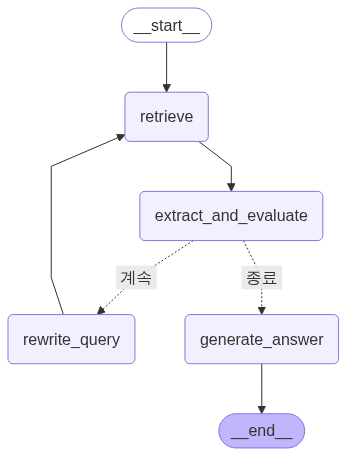

In [81]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# 그래프 생성
workflow = StateGraph(EcommerceRagState)

# 노드 추가
workflow.add_node("retrieve", retrieve_documents)
workflow.add_node("extract_and_evaluate", extract_and_evaluate_information)
workflow.add_node("rewrite_query", rewrite_query)
workflow.add_node("generate_answer", generate_node_answer)


# 엣지 추가
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "extract_and_evaluate")

# 조건부 엣지 추가
workflow.add_conditional_edges(
    "extract_and_evaluate",
    should_continue,
    {
        "계속": "rewrite_query",
        "종료": "generate_answer"
    }
)
workflow.add_edge("rewrite_query", "retrieve")
workflow.add_edge("generate_answer", END)

# 그래프 컴파일
ecommerce_law_agent = workflow.compile()

# 그래프 시각화
display(Image(ecommerce_law_agent.get_graph().draw_mermaid_png()))

In [82]:
inputs = {"question": "환불이 거절되었을 때 소비자가 취할 수 있는 조치가 있나요?"}
for output in ecommerce_law_agent.stream(inputs):
    for key, value in output.items():
        # 노드 출력
        pprint(f"Node '{key}':")
        pprint(f"Value: {value}", indent=2, width=80, depth=None)
    print("\n----------------------------------------------------------\n")

---문서 검색---
"Node 'retrieve':"
("Value: {'documents': [Document(metadata={'chapter': '', 'name': "
 "'생활법령소비자QnA', 'source': '공정거래위원회_소비자민원'}, page_content='question: 1) 중도 "
 '계약해지\\n answer: 사업자 사정으로 인한 경우〔기납부 수강료의 전액 - (당해 교육과정의 시간당 수강료 × 당해 사유 발생 '
 '시까지의 교육시간수)〕환급 가능하며, 소비자 사정으로 인한 경우 〔기납부 수강료의 전액 - (당해 교육과정의 시간당 수강료 × 수강 포기 '
 '의사표시 시까지의 교육시간수)〕 × 50% 반환 가능합니다.  단, 수강자가 교육 기간이 종료되기 이전에 운전면허시험에 합격한 경우에는 '
 "학원은 미교육 시간수에 대한 수강료등의 환급의무가 없습니다. '), Document(metadata={'chapter': '운전강습', "
 "'name': '생활법령소비자QnA', 'source': '공정거래위원회_소비자민원'}, page_content='question: 1) "
 '중도 계약해지\\n answer: 사업자 사정으로 인한 경우〔기납부 수강료의 전액 - (당해 교육과정의 시간당 수강료 × 당해 사유 발생 '
 '시까지의 교육시간수)〕환급 가능하며, 소비자 사정으로 인한 경우 〔기납부 수강료의 전액 - (당해 교육과정의 시간당 수강료 × 수강 포기 '
 '의사표시 시까지의 교육시간수)〕 × 50% 반환 가능합니다.  단, 수강자가 교육 기간이 종료되기 이전에 운전면허시험에 합격한 경우에는 '
 "학원은 미교육 시간수에 대한 수강료등의 환급의무가 없습니다. ')]}")

----------------------------------------------------------

---정보 추출 및 평가---
"Node 'extract_and_evaluate':"
"Value: {'num_generations': 1, 

In [83]:
print(value['node_answer'])

1. 질문에 대한 직접적인 답변  
전자상거래에서 소비자 보호를 위해 「전자상거래 등에서의 소비자보호에 관한 법률」(이하 전자상거래법)에는 다양한 조항이 마련되어 있습니다. 주요 내용으로는 청약철회권, 정보제공의무, 계약서 교부, 소비자 피해보상, 분쟁해결 절차 등이 있습니다(출처: 전자상거래법).

2. 관련 법률 조항 및 해석  
- 청약철회권: 소비자는 재화 등을 공급받은 날로부터 7일 이내에 청약을 철회할 수 있습니다(출처: 전자상거래법 제17조).
- 정보제공의무: 사업자는 상품의 주요 내용, 가격, 배송비, 청약철회 조건 등 소비자가 거래에 필요한 정보를 명확하게 제공해야 합니다(출처: 전자상거래법 제13조).
- 계약서 교부: 전자상거래 사업자는 소비자에게 계약의 주요 내용을 확인할 수 있는 서면(전자문서 포함)을 제공해야 합니다(출처: 전자상거래법 제8조).
- 소비자 피해보상: 소비자 피해가 발생한 경우, 사업자는 소비자분쟁해결기준에 따라 신속하게 보상해야 합니다(출처: 전자상거래법 제21조).
- 분쟁해결 절차: 소비자는 한국소비자원 등 분쟁조정기관을 통해 분쟁 해결을 신청할 수 있습니다(출처: 전자상거래법 제30조).

3. 추가 설명 또는 예시  
예를 들어, 온라인 쇼핑몰에서 상품을 구매한 후 단순 변심으로 7일 이내에 반품을 요청하면, 특별한 사유(예: 포장이 훼손된 경우 등)가 없는 한 판매자는 이를 거부할 수 없습니다(출처: 전자상거래법 제17조). 또한, 상품의 가격, 배송비, 환불 조건 등이 명확히 안내되지 않았다면, 소비자는 불리한 계약을 취소할 수 있습니다(출처: 전자상거래법 제13조).

4. 결론 및 요약  
전자상거래법은 소비자의 권익 보호를 위해 청약철회권, 정보제공의무, 계약서 교부, 피해보상, 분쟁해결 등 다양한 조항을 두고 있습니다. 소비자는 이러한 권리를 적극적으로 활용할 수 있으며, 사업자는 관련 법률을 준수해야 합니다(출처: 전자상거래법).


#### (3) 주택임대차보호법 RAG 에이전트

In [84]:
# 주택임대차보호법
class HousingRagState(CorrectiveRagState):
    rewritten_query: str   # 재작성한 질문 
    extracted_info: Optional[ExtractedInformation]   # 추출된 정보 조각 
    node_answer: Optional[str] 

In [85]:
from langchain_core.prompts import ChatPromptTemplate
from typing import Literal

def retrieve_documents(state: HousingRagState) -> HousingRagState:
    print("---문서 검색---")
    query = state.get("rewritten_query", state["question"])
    docs = housing_law_search.invoke(query)
    return {"documents": docs}

def extract_and_evaluate_information(state: HousingRagState) -> HousingRagState:
    print("---정보 추출 및 평가---")
    extracted_strips = []

    for doc in state["documents"]:
        extract_prompt = ChatPromptTemplate.from_messages([
            ("system", """당신은 주택임대차보호법 전문가입니다. 주어진 문서에서 질문과 관련된 주요 사실과 정보를 3~5개 정도 추출하세요. 
            각 추출된 정보에 대해 다음 두 가지 측면을 0에서 1 사이의 점수로 평가하세요:
            1. 질문과의 관련성
            2. 답변의 충실성 (질문에 대한 완전하고 정확한 답변을 제공할 수 있는 정도)
            
            추출 형식:
            1. [추출된 정보]
            - 관련성 점수: [0-1 사이의 점수]
            - 충실성 점수: [0-1 사이의 점수]
            2. [추출된 정보]
            - 관련성 점수: [0-1 사이의 점수]
            - 충실성 점수: [0-1 사이의 점수]
            ...
            
            마지막으로, 추출된 정보를 종합하여 질문에 대한 전반적인 답변 가능성을 0에서 1 사이의 점수로 평가하세요."""),
            ("human", "[질문]\n{question}\n\n[문서 내용]\n{document_content}")
        ])

        extract_llm = llm.with_structured_output(ExtractedInformation)

        extracted_data = extract_llm.invoke(extract_prompt.format(
            question=state["question"],
            document_content=doc.page_content
        ))

        if extracted_data.query_relevance < 0.8:
            continue

        for strip in extracted_data.strips:
            if strip.relevance_score > 0.7 and strip.faithfulness_score > 0.7:
                extracted_strips.append(strip)

    return {
        "extracted_info": extracted_strips,
        "num_generations": state.get("num_generations", 0) + 1
    }

def rewrite_query(state: HousingRagState) -> HousingRagState:
    print("---쿼리 재작성---")

    rewrite_prompt = ChatPromptTemplate.from_messages([
        ("system", """당신은 주택임대차보호법 전문가입니다. 주어진 원래 질문과 추출된 정보를 바탕으로, 더 관련성 있고 충실한 정보를 찾기 위해 검색 쿼리를 개선해주세요.

        다음 사항을 고려하여 검색 쿼리를 개선하세요:
        1. 원래 질문의 핵심 요소
        2. 추출된 정보의 관련성 점수
        3. 추출된 정보의 충실성 점수
        4. 부족한 정보나 더 자세히 알아야 할 부분

        개선된 검색 쿼리 작성 단계:
        1. 2-3개의 검색 쿼리를 제안하세요.
        2. 각 쿼리는 구체적이고 간결해야 합니다(5-10 단어 사이).
        3. 주택임대차보호법과 관련된 전문 용어를 적절히 활용하세요.
        4. 각 쿼리 뒤에는 해당 쿼리를 제안한 이유를 간단히 설명하세요.

        출력 형식:
        1. [개선된 검색 쿼리 1]
        - 이유: [이 쿼리를 제안한 이유 설명]
        2. [개선된 검색 쿼리 2]
        - 이유: [이 쿼리를 제안한 이유 설명]
        3. [개선된 검색 쿼리 3]
        - 이유: [이 쿼리를 제안한 이유 설명]

        마지막으로, 제안된 쿼리 중 가장 효과적일 것 같은 쿼리를 선택하고 그 이유를 설명하세요."""),
        ("human", "원래 질문: {question}\n\n추출된 정보:\n{extracted_info}\n\n위 지침에 따라 개선된 검색 쿼리를 작성해주세요.")
    ])

    extracted_info_str = "\n".join([strip.content for strip in state["extracted_info"]])
    
    rewrite_llm = llm.with_structured_output(RefinedQuestion)

    response = rewrite_llm.invoke(rewrite_prompt.format(
        question=state["question"],
        extracted_info=extracted_info_str
    ))
    
    return {"rewritten_query": response.question_refined}

def generate_node_answer(state: HousingRagState) -> HousingRagState:
    print("---답변 생성---")

    answer_prompt = ChatPromptTemplate.from_messages([
        ("system", """당신은 주택임대차보호법 전문가입니다. 주어진 질문과 추출된 정보를 바탕으로 답변을 생성해주세요. 
        답변은 마크다운 형식으로 작성하며, 각 정보의 출처를 명확히 표시해야 합니다. 
        답변 구조:
        1. 질문에 대한 직접적인 답변
        2. 관련 법률 조항 및 해석
        3. 추가 설명 또는 예시 (필요한 경우)
        4. 결론 및 요약
        각 섹션에서 사용된 정보의 출처를 괄호 안에 명시하세요. 예: (출처: 주택임대차보호법 제15조)"""),
        ("human", "질문: {question}\n\n추출된 정보:\n{extracted_info}\n\n위 지침에 따라 최종 답변을 작성해주세요.")
    ])

    extracted_info_str = "\n".join([f"내용: {strip.content}\n출처: {strip.source}\n관련성: {strip.relevance_score}\n충실성: {strip.faithfulness_score}" for strip in state["extracted_info"]])

    node_answer = llm.invoke(answer_prompt.format(
        question=state["question"],
        extracted_info=extracted_info_str
    ))

    return {"node_answer": node_answer.content}

def should_continue(state: HousingRagState) -> Literal["계속", "종료"]:
    if state["num_generations"] >= 2:
        return "종료"
    if len(state["extracted_info"]) >= 1:
        return "종료"
    return "계속"

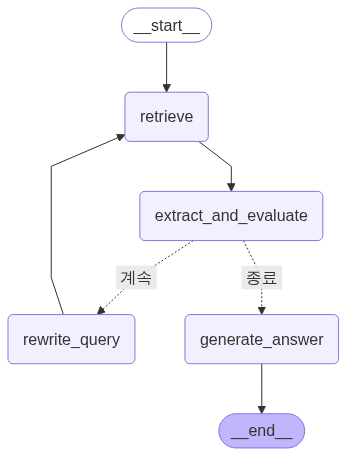

In [86]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# 그래프 생성
workflow = StateGraph(HousingRagState)

# 노드 추가
workflow.add_node("retrieve", retrieve_documents)
workflow.add_node("extract_and_evaluate", extract_and_evaluate_information)
workflow.add_node("rewrite_query", rewrite_query)
workflow.add_node("generate_answer", generate_node_answer)


# 엣지 추가
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "extract_and_evaluate")

# 조건부 엣지 추가
workflow.add_conditional_edges(
    "extract_and_evaluate",
    should_continue,
    {
        "계속": "rewrite_query",
        "종료": "generate_answer"
    }
)
workflow.add_edge("rewrite_query", "retrieve")
workflow.add_edge("generate_answer", END)

# 그래프 컴파일
housing_law_agent = workflow.compile()

# 그래프 시각화
display(Image(housing_law_agent.get_graph().draw_mermaid_png()))

In [87]:
inputs = {"question": "대리인과 아파트 임대차 계약을 체결할 때 주의해야 할 점은 무엇인가요?"}
for output in housing_law_agent.stream(inputs):
    for key, value in output.items():
        # 노드 출력
        pprint(f"Node '{key}':")
        pprint(f"Value: {value}", indent=2, width=80, depth=None)
    print("\n----------------------------------------------------------\n")

---문서 검색---
"Node 'retrieve':"
("Value: {'documents': [Document(metadata={'name': '주택임대차보호법', "
 "'source': 'data/주택임대차보호법(법률)(제19356호)(20230719).pdf'}, "
 "page_content='[법률정보]\\n다음 조항은 주택임대차보호법에서 발췌한 "
 '내용입니다.\\n\\n[법률조항]\\n제3조의7(임대인의 정보 제시 의무) 임대차계약을 체결할 때 임대인은 다음 각 호의 사항을 '
 '임차인에게 제시하여야 한\\n다.\\n1. 제3조의6제3항에 따른 해당 주택의 확정일자 부여일, 차임 및 보증금 등 정보. 다만, '
 '임대인이 임대차계약을 체결\\n하기 전에 제3조의6제4항에 따라 동의함으로써 이를 갈음할 수 있다. \\n2. 「국세징수법」 제108조에 '
 '따른 납세증명서 및 「지방세징수법」 제5조제2항에 따른 납세증명서. 다만, 임대인이 임\\n대차계약을 체결하기 전에 「국세징수법」 '
 '제109조제1항에 따른 미납국세와 체납액의 열람 및 「지방세징수법」 제 \\n6조제1항에 따른 미납지방세의 열람에 각각 동의함으로써 이를 '
 "갈음할 수 있다. \\n[본조신설 2023. 4. 18.]'), Document(metadata={'name': "
 "'주택임대차보호법', 'source': "
 "'data/주택임대차보호법(법률)(제19356호)(20230719).pdf'}, "
 "page_content='[법률정보]\\n다음 조항은 주택임대차보호법에서 발췌한 "
 '내용입니다.\\n\\n[법률조항]\\n제30조(주택임대차표준계약서 사용) 주택임대차계약을 서면으로 체결할 때에는 법무부장관이 '
 '국토교통부장관과 협의\\n하여 정하는 주택임대차표준계약서를 우선적으로 사용한다. 다만, 당사자가 다른 서식

In [88]:
print(value['node_answer'])

1. 질문에 대한 직접적인 답변  
아파트 임대차 계약을 대리인을 통해 체결할 때에는, 대리인의 권한을 명확히 확인하고, 임대차계약에 필요한 정보(확정일자, 차임, 보증금 등)와 납세증명서 또는 세금 체납 내역 열람 동의 여부를 반드시 확인해야 합니다. 또한, 대리인이 임대인 또는 임차인을 적법하게 대리할 수 있는지(위임장, 신분증 등)도 꼼꼼히 점검해야 합니다. (출처: 주택임대차보호법 제3조의7 제1호, 제2호)

2. 관련 법률 조항 및 해석  
- 주택임대차보호법 제3조의7 제1호에 따르면, 임대인은 임차인에게 확정일자 부여일, 차임, 보증금 등 임대차계약의 주요 정보를 제시해야 하며, 임대인이 사전에 동의하면 이를 갈음할 수 있습니다.  
- 같은 법 제3조의7 제2호는 임대인이 국세 및 지방세의 납세증명서를 임차인에게 제시해야 하며, 임대인이 사전에 미납세금 열람에 동의하면 증명서 제시를 생략할 수 있음을 규정합니다.  
(출처: 주택임대차보호법 제3조의7 제1호, 제2호)

3. 추가 설명 또는 예시  
예를 들어, 임대인의 대리인이 계약을 체결할 경우, 임차인은 대리인이 임대인으로부터 적법하게 위임받았는지(위임장, 인감증명서 등) 확인해야 하며, 임대차계약서에 임대인의 납세증명서 또는 미납세금 열람 동의서가 첨부되어 있는지 확인해야 합니다. 만약 이러한 서류가 없거나 대리인의 권한이 불분명하다면, 추후 법적 분쟁이 발생할 수 있습니다.

4. 결론 및 요약  
아파트 임대차 계약을 대리인을 통해 체결할 때에는  
- 대리인의 적법한 권한(위임장 등) 확인  
- 임대차계약의 주요 정보(확정일자, 차임, 보증금 등) 확인  
- 납세증명서 또는 미납세금 열람 동의서 확인  
등을 반드시 점검해야 하며, 관련 서류가 모두 구비되어 있는지 꼼꼼히 확인하는 것이 중요합니다.  
(출처: 주택임대차보호법 제3조의7 제1호, 제2호)


#### (4) 웹 검색 기반 RAG 에이전트

In [89]:
# 웹 검색 도구 
class SearchRagState(CorrectiveRagState):
    rewritten_query: str   # 재작성한 질문 
    extracted_info: Optional[ExtractedInformation]   # 추출된 정보 조각 
    node_answer: Optional[str] 

In [91]:
from langchain_core.prompts import ChatPromptTemplate
from typing import Literal

def retrieve_documents(state: SearchRagState) -> SearchRagState:
    print("---문서 검색---")
    query = state.get("rewritten_query", state["question"])
    docs = web_search.invoke(query)
    return {"documents": docs}

def extract_and_evaluate_information(state: SearchRagState) -> SearchRagState:
    print("---정보 추출 및 평가---")
    extracted_strips = []

    for doc in state["documents"]:
        extract_prompt = ChatPromptTemplate.from_messages([
            ("system", """당신은 인터넷 정보 검색 전문가입니다. 주어진 문서에서 질문과 관련된 주요 사실과 정보를 3~5개 정도 추출하세요. 
            각 추출된 정보에 대해 다음 두 가지 측면을 0에서 1 사이의 점수로 평가하세요:
            1. 질문과의 관련성
            2. 답변의 충실성 (질문에 대한 완전하고 정확한 답변을 제공할 수 있는 정도)
            
            추출 형식:
            1. [추출된 정보]
            - 관련성 점수: [0-1 사이의 점수]
            - 충실성 점수: [0-1 사이의 점수]
            2. [추출된 정보]
            - 관련성 점수: [0-1 사이의 점수]
            - 충실성 점수: [0-1 사이의 점수]
            ...
            
            마지막으로, 추출된 정보를 종합하여 질문에 대한 전반적인 답변 가능성을 0에서 1 사이의 점수로 평가하세요."""),
            ("human", "[질문]\n{question}\n\n[문서 내용]\n{document_content}")
        ])

        extract_llm = llm.with_structured_output(ExtractedInformation)

        extracted_data = extract_llm.invoke(extract_prompt.format(
            question=state["question"],
            document_content=doc.page_content
        ))

        if extracted_data.query_relevance < 0.8:
            continue

        for strip in extracted_data.strips:
            if strip.relevance_score > 0.7 and strip.faithfulness_score > 0.7:
                extracted_strips.append(strip)

    return {
        "extracted_info": extracted_strips,
        "num_generations": state.get("num_generations", 0) + 1
    }

def rewrite_query(state: SearchRagState) -> SearchRagState:
    print("---쿼리 재작성---")

    rewrite_prompt = ChatPromptTemplate.from_messages([
        ("system", """당신은 인터넷 정보 검색 전문가입니다. 주어진 원래 질문과 추출된 정보를 바탕으로, 더 관련성 있고 충실한 정보를 찾기 위해 검색 쿼리를 개선해주세요.

        다음 사항을 고려하여 검색 쿼리를 개선하세요:
        1. 원래 질문의 핵심 요소
        2. 추출된 정보의 관련성 점수
        3. 추출된 정보의 충실성 점수
        4. 부족한 정보나 더 자세히 알아야 할 부분

        개선된 검색 쿼리 작성 단계:
        1. 2-3개의 검색 쿼리를 제안하세요.
        2. 각 쿼리는 구체적이고 간결해야 합니다(5-10 단어 사이).
        3. 질문과 관련된 전문 용어를 적절히 활용하세요.
        4. 각 쿼리 뒤에는 해당 쿼리를 제안한 이유를 간단히 설명하세요.

        출력 형식:
        1. [개선된 검색 쿼리 1]
        - 이유: [이 쿼리를 제안한 이유 설명]
        2. [개선된 검색 쿼리 2]
        - 이유: [이 쿼리를 제안한 이유 설명]
        3. [개선된 검색 쿼리 3]
        - 이유: [이 쿼리를 제안한 이유 설명]

        마지막으로, 제안된 쿼리 중 가장 효과적일 것 같은 쿼리를 선택하고 그 이유를 설명하세요."""),
        ("human", "원래 질문: {question}\n\n추출된 정보:\n{extracted_info}\n\n위 지침에 따라 개선된 검색 쿼리를 작성해주세요.")
    ])

    extracted_info_str = "\n".join([strip.content for strip in state["extracted_info"]])
    
    rewrite_llm = llm.with_structured_output(RefinedQuestion)

    response = rewrite_llm.invoke(rewrite_prompt.format(
        question=state["question"],
        extracted_info=extracted_info_str
    ))
    
    return {"rewritten_query": response.question_refined}

def generate_node_answer(state: SearchRagState) -> SearchRagState:
    print("---답변 생성---")

    answer_prompt = ChatPromptTemplate.from_messages([
        ("system", """당신은 인터넷 정보 검색 전문가입니다. 주어진 질문과 추출된 정보를 바탕으로 답변을 생성해주세요. 
        답변은 마크다운 형식으로 작성하며, 각 정보의 출처를 명확히 표시해야 합니다. 
        답변 구조:
        1. 질문에 대한 직접적인 답변
        2. 관련 출처 및 링크
        3. 추가 설명 또는 예시 (필요한 경우)
        4. 결론 및 요약
        각 섹션에서 사용된 정보의 출처를 괄호 안에 명시하세요. 블로그보다는 공식홈페이지를 우선적으로 명시하세요. 예: (출처: 블로그 (www.blog.com/page/001)"""),
        ("human", "질문: {question}\n\n추출된 정보:\n{extracted_info}\n\n위 지침에 따라 최종 답변을 작성해주세요.")
    ])

    extracted_info_str = "\n".join([f"내용: {strip.content}\n출처: {strip.source}\n관련성: {strip.relevance_score}\n충실성: {strip.faithfulness_score}" for strip in state["extracted_info"]])

    node_answer = llm.invoke(answer_prompt.format(
        question=state["question"],
        extracted_info=extracted_info_str
    ))

    return {"node_answer": node_answer.content}

def should_continue(state: SearchRagState) -> Literal["계속", "종료"]:
    if state["num_generations"] >= 2:
        return "종료"
    if len(state["extracted_info"]) >= 1:
        return "종료"
    return "계속"

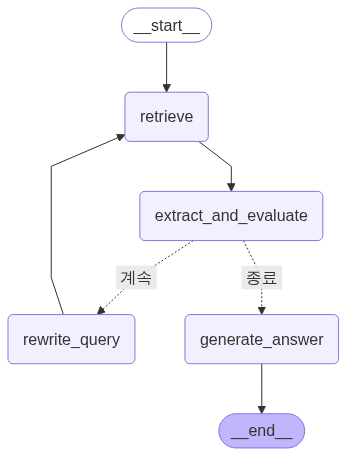

In [92]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# 그래프 생성
workflow = StateGraph(SearchRagState)

# 노드 추가
workflow.add_node("retrieve", retrieve_documents)
workflow.add_node("extract_and_evaluate", extract_and_evaluate_information)
workflow.add_node("rewrite_query", rewrite_query)
workflow.add_node("generate_answer", generate_node_answer)


# 엣지 추가
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "extract_and_evaluate")

# 조건부 엣지 추가
workflow.add_conditional_edges(
    "extract_and_evaluate",
    should_continue,
    {
        "계속": "rewrite_query",
        "종료": "generate_answer"
    }
)
workflow.add_edge("rewrite_query", "retrieve")
workflow.add_edge("generate_answer", END)

# 그래프 컴파일
search_web_agent = workflow.compile()

# 그래프 시각화
display(Image(search_web_agent.get_graph().draw_mermaid_png()))

In [93]:
inputs = {"question": "대리인과 아파트 임대차 계약을 체결할 때 주의해야 할 점은 무엇인가요?"}
for output in search_web_agent.stream(inputs):
    for key, value in output.items():
        # 노드 출력
        pprint(f"Node '{key}':")
        pprint(f"Value: {value}", indent=2, width=80, depth=None)
    print("\n----------------------------------------------------------\n")

---문서 검색---
"Node 'retrieve':"
("Value: {'documents': [Document(metadata={'source': 'web search', 'url': "
 "'https://m.blog.naver.com/mathmaster7668/223053556755'}, "
 "page_content='<Document "
 'href="https://m.blog.naver.com/mathmaster7668/223053556755"/>\\n카테고리 이동 집주인 '
 '대신 대리인과 임대차계약시 주의할 점 5가지 Q. 집주인 대신 대리인과 임대차계약시 주의할 점은? 그러나, 현업에 있다 보면 부득이 하게 '
 '임대인 또는 매도인이 대리인을 내보내는 경우가 종종 있습니다. 대리 임대차계약시 주의사항 5가지 임대차 계약이라면, 그리고 반드시 '
 '위임장에는 일반도장이 아닌 임대인(집주인)의 인감도장이 날인되어야 합니다. 3. 계약서 특약에 명시 임대차계약을 체결한 계약 상대방은  '
 "소유자가 아닌  \\'소유자의 대리인\\'이기 때문입니다. 임대차 대리계약 요약! 3. 계약서 특약에 명시 민법 제118조(대리권의 "
 '범위) 제115조(본인을 위한 것임을 표시하지 아니한 행위) 대리인이 본인을 위한 것임을 표시하지 아니한 때에는 그 의사표시는 자기를 '
 '위한 것으로 본다. https://blog.naver.com/mathmaster7668/222833950660 Q. 매매계약이 진행중인 '
 "아파트 전세계약을 체결하려고 하는데, \\'부동산\\'에서 매수자(새로운 집... blog.naver.com "
 'https://blog.naver.com/mathmaster7668/222841733223 Q. 소액임차인이면 경매에서 보증금 전액 '
 '무조건 전액 다 배당 받나요? blog.naver.com '
 'https://blog.naver.com/mathmaster7668/223751180219 부동산 거래 현장에서 가장 많은

In [94]:
print(value['node_answer'])

1. 질문에 대한 직접적인 답변  
아파트 임대차 계약을 임대인의 대리인과 체결할 때에는 다음 사항을 반드시 주의해야 합니다.

- 대리인이 임대인으로부터 정식으로 위임받았는지 확인해야 하며, 이를 증명하는 위임장과 임대인의 인감도장이 날인된 인감증명서를 반드시 받아야 합니다.  
- 임대차계약서에는 계약 상대방이 소유자가 아닌 '소유자의 대리인'임을 특약란 등에 명확히 기재해야 하며, 민법 제115조에 따라 대리계약임을 표시하지 않으면 대리인이 자기 자신을 위한 계약으로 간주될 수 있으므로 반드시 대리계약임을 명확히 해야 합니다.  
- 공동소유 아파트의 경우, 1/2 이하의 지분을 가진 자와 계약을 체결할 때에는 나머지 지분권자의 동의를 받는 것이 안전합니다.  
- 임차인이 임대인의 동의 없이 임차권을 양도하거나 임차물을 전대하는 것은 금지되어 있으니, 계약 체결 시 이 부분도 유의해야 합니다.  
(출처: 네이버 블로그(https://m.blog.naver.com/mathmaster7668/223053556755), 티스토리(https://yklawyer.tistory.com/7564))

2. 관련 출처 및 링크  
- [네이버 블로그: 임대차계약 대리인과 체결 시 주의사항](https://m.blog.naver.com/mathmaster7668/223053556755)  
- [티스토리: 임대차계약 대리인 관련 법률정보](https://yklawyer.tistory.com/7564)  

3. 추가 설명 또는 예시  
예를 들어, 임대인의 친척이나 중개업자가 대리인으로 나와 계약을 진행할 경우, 반드시 임대인 명의의 위임장과 인감증명서를 확인해야 하며, 계약서에 '임대인의 대리인 ○○○'로 명확히 기재해야 합니다. 만약 이러한 절차를 생략하면, 추후 임대차계약의 효력에 문제가 생길 수 있습니다. 또한, 공동소유 아파트라면 모든 소유자의 동의가 필요할 수 있으니, 등기부등본을 통해 소유관계를 확인하는 것이 안전합니다.  

4. 결론 및 요약  
임대

### 3-2. 질문 라우팅 
- 사용자의 질문을 분석하여 적절한 에이전트를 선택 (Adaptive RAG 적용)

In [95]:
from typing import Annotated
from operator import add

# 메인 그래프 상태 정의
class ResearchAgentState(TypedDict):
    question: str
    answers: Annotated[List[str], add]
    final_answer: str
    datasources: List[str]
    evaluation_report: Optional[dict]
    user_decision: Optional[str]

In [97]:
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

# 라우팅 결정을 위한 데이터 모델
class ToolSelector(BaseModel):
    """Routes the user question to the most appropriate tool."""
    tool: Literal["search_ecommerce",  "search_housing", "search_web"] = Field(
        description="Select one of the tools, based on the user's question.",
    )

class ToolSelectors(BaseModel):
    """Select the appropriate tools that are suitable for the user question."""
    tools: List[ToolSelector] = Field(
        description="Select one or more tools, based on the user's question.",
    )

# 구조화된 출력을 위한 LLM 설정
structured_llm_tool_selector = llm.with_structured_output(ToolSelectors)

# 라우팅을 위한 프롬프트 템플릿
system = dedent("""
You are an AI legal assistant responsible for determining which tool to use to answer a user's question based on the legal domain involved.

Each tool corresponds to a legal category:

- 'search_ecommerce': For questions related to commerce between businesses and consumers — including online purchases, refunds, delivery issues, subscription cancellations, and consumer protection.
- 'search_housing': For questions involving residential leases, rental agreements, tenant rights, housing protections, or address registration.
- 'search_web': For questions outside specific laws (e.g., current events, general legal news, public policy, or laws unrelated to ecommerce or housing).

Make your decision based on the **legal theme and domain** of the question, not just keywords.

Examples:
- "전자제품 환불 거부에 대응하려면 어떻게 해야 하나요?" → tools = ['search_ecommerce']
- "이사하고 나서 전입신고 안 하면 어떤 불이익이 있나요?" → tools = ['search_housing']
- "쇼핑몰에서 교환을 거절하는 건 정당한가요?" → tools = ['search_ecommerce']
- "주택임대차보호법에서 임차인이 보호받는 조건은?" → tools = ['search_housing']
- "노동자 권리에 대해 알고 싶어요" → tools = ['web_search']  
""")

route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

# 질문 라우터 정의
question_tool_router = route_prompt | structured_llm_tool_selector

# 테스트 실행
print(question_tool_router.invoke({"question": "건강기능식품이 뭔가요? 약이랑 다른가요?"}))
print(question_tool_router.invoke({"question": "어떤 전기매트가 안전한가요?"}))
print(question_tool_router.invoke({"question": "택배기사가 배송 중 물건을 파손했어요. 어떻게 해야 하나요?"}))

tools=[ToolSelector(tool='search_web')]
tools=[ToolSelector(tool='search_web')]
tools=[ToolSelector(tool='search_web')]


In [98]:
# 질문 라우팅 노드 
def analyze_question_tool_search(state: ResearchAgentState):
    question = state["question"]
    result = question_tool_router.invoke({"question": question})
    datasources = [tool.tool for tool in result.tools]
    return {"datasources": datasources}


def route_datasources_tool_search(state: ResearchAgentState) -> List[str]:
    datasources = set(state['datasources'])
    valid_sources = {"search_ecommerce",  "search_housing", "search_web"}
    
    if datasources.issubset(valid_sources):
        return list(datasources)
    
    return list(valid_sources)

In [99]:
# 노드 정의 
def ecommerce_rag_node(state: EcommerceRagState, input=ResearchAgentState) -> ResearchAgentState:
    print("--- 개인정보보호법 전문가 에이전트 시작 ---")
    question = state["question"]
    answer = ecommerce_law_agent.invoke({"question": question})
    return {"answers": [answer["node_answer"]]}


def housing_rag_node(state: HousingRagState, input=ResearchAgentState) -> ResearchAgentState:
    print("--- 주택임대차보호법 전문가 에이전트 시작 ---")
    question = state["question"]
    answer = housing_law_agent.invoke({"question": question})
    return {"answers": [answer["node_answer"]]}

def web_rag_node(state: SearchRagState, input=ResearchAgentState) -> ResearchAgentState:
    print("--- 인터넷 검색 전문가 에이전트 시작 ---")
    question = state["question"]
    answer = search_web_agent.invoke({"question": question})
    return {"answers": [answer["node_answer"]]}


In [100]:
# 최종 답변 생성 노드
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

# RAG 프롬프트 정의
rag_prompt = ChatPromptTemplate.from_messages([
    ("system", """당신은 주어진 문서를 기반으로 질문에 법적으로 정확하게 답변하는 AI 어시스턴트입니다. 아래 지침을 따르세요:

1. 주어진 문서에서만 정보를 사용하세요.
2. 관련 정보가 없다면 "제공된 정보로는 충분한 답변을 할 수 없습니다."라고 답하세요.
3. 답변 후 반드시 '관련 법령'을 JSON 배열로 명시하세요. (예: ["민법 제635조", "주택임대차보호법 제4조"])
4. 각 문장에 출처를 명시하세요:
    - 법령은 "법률명 제X조 Y항"
    - 웹 정보는 "출처 제목 (URL)"
5. 추론이나 문서 외 정보는 사용하지 마세요.
6. 답변은 간결하고 명확하게 작성하세요.
7. 중복 정보는 병합하여 출처를 함께 명시하세요.
8. 문장이 너무 길어지지 않도록 하세요. 문단을 나누고, 적절한 줄바꿈(\\n)을 사용해 가독성을 높이세요.
9. 각 문장은 띄어쓰기를 정확하게 하고, 한 문단에 너무 많은 정보를 넣지 마세요.

출력 예시:
🔍 질문 주신 내용에 대해 답변 드리겠습니다.
📃 관련 법령: "주택임대차보호법 제6조" (없을 경우 생략)
    "계약 종료 후 임차인이 퇴거하지 않으면 묵시적으로 계약이 갱신됩니다. (주택임대차보호법 제6조)"
"""),
    ("human", "다음 질문에 대해 아래 문서를 참고하여 답변하세요:\n\n[문서]\n{documents}\n\n[질문]\n{question}")
])

def answer_final(state: ResearchAgentState) -> ResearchAgentState:
    """
    Generate answer using the retrieved_documents
    """
    print("---최종 답변---")
    question = state["question"]
    documents = state.get("answers", [])
    if not isinstance(documents, list):
        documents = [documents]

    # 문서 내용을 문자열로 결합 
    documents_text = "\n\n".join(documents)

    # RAG generation
    rag_chain = rag_prompt | llm | StrOutputParser()
    generation = rag_chain.invoke({"documents": documents_text, "question": question})
    return {"final_answer": generation, "question":question}


# LLM Fallback 프롬프트 정의
fallback_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are an AI assistant helping with various topics. Follow these guidelines:

1. Provide accurate and helpful information to the best of your ability.
2. Express uncertainty when unsure; avoid speculation.
3. Keep answers concise yet informative.
4. Respond ethically and constructively.
5. Mention reliable general sources when applicable."""),
    ("human", "{question}"),
])

def llm_fallback(state: ResearchAgentState) -> ResearchAgentState:
    """
    Generate answer using the LLM without context
    """
    print("---Fallback 답변---")
    question = state["question"]
    
    # LLM chain
    llm_chain = fallback_prompt | llm | StrOutputParser()
    
    generation = llm_chain.invoke({"question": question})
    return {"final_answer": generation, "question":question}

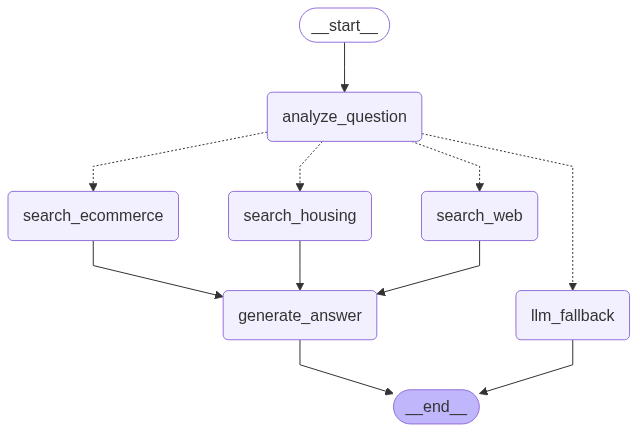

In [101]:
# 노드 정의를 딕셔너리로 관리
nodes = {
    "analyze_question": analyze_question_tool_search,
    "search_ecommerce": ecommerce_rag_node,
    "search_housing": housing_rag_node,
    "search_web": web_rag_node,
    "generate_answer": answer_final,
    "llm_fallback": llm_fallback
}

# 그래프 생성을 위한 StateGraph 객체를 정의
search_builder = StateGraph(ResearchAgentState)

# 노드 추가
for node_name, node_func in nodes.items():
    search_builder.add_node(node_name, node_func)

# 엣지 추가 (병렬 처리)
search_builder.add_edge(START, "analyze_question")
search_builder.add_conditional_edges(
    "analyze_question",
    route_datasources_tool_search,
    ["search_ecommerce", "search_housing", "search_web", "llm_fallback"]
)

# 검색 노드들을 generate_answer에 연결
for node in ["search_ecommerce", "search_housing", "search_web"]:
    search_builder.add_edge(node, "generate_answer")

search_builder.add_edge("generate_answer", END)
search_builder.add_edge("llm_fallback", END)

# 그래프 컴파일
rag_search_graph = search_builder.compile()

# 그래프 시각화 
display(Image(rag_search_graph.get_graph().draw_mermaid_png()))

In [103]:
inputs = {"question": "택배가 운송 도중 분실되었는데 물품이 분실된 경우에도 택배비를 내야하나요?"}
for output in rag_search_graph.stream(inputs):
    for key, value in output.items():
        # 노드 출력
        pprint(f"Node '{key}':")
        pprint(f"Value: {value}", indent=2, width=80, depth=None)
    print("\n----------------------------------------------------------\n")

"Node 'analyze_question':"
"Value: {'datasources': ['search_web']}"

----------------------------------------------------------

--- 인터넷 검색 전문가 에이전트 시작 ---
---문서 검색---
---정보 추출 및 평가---
---답변 생성---
"Node 'search_web':"
("Value: {'answers': ['1. 질문에 대한 직접적인 답변  \\n택배가 운송 도중 분실된 경우, 일반적으로 물품의 분실에 "
 '대한 보상뿐만 아니라 이미 지불한 택배비도 환급받을 수 있습니다. 즉, 물품이 분실된 경우 택배비를 추가로 부담하지 않아도 되며, 환급 '
 '절차를 통해 돌려받을 수 있습니다. (출처: wisetripguide '
 '(https://wisetripguide.com/택배-분실-시-보상받는-절차-정리/))\\n\\n2. 관련 출처 및 링크  \\n- '
 'wisetripguide: [택배 분실 시 보상받는 절차 '
 '정리](https://wisetripguide.com/택배-분실-시-보상받는-절차-정리/)\\n\\n3. 추가 설명 또는 예시  '
 '\\n택배가 분실된 경우, 택배사 고객센터에 분실 사실을 신고하고, 보상 절차를 진행해야 합니다. 이 과정에서 운송장, 결제 내역 등 '
 '관련 서류를 제출하면, 택배사는 물품가액과 함께 택배비도 환급해주는 것이 일반적입니다. 다만, 각 택배사별로 세부 정책이 다를 수 '
 '있으니, 이용한 택배사의 공식 홈페이지나 고객센터를 통해 정확한 안내를 받는 것이 좋습니다.\\n\\n4. 결론 및 요약  \\n운송 '
 '도중 택배가 분실된 경우, 물품 보상과 함께 이미 지불한 택배비도 환급받을 수 있습니다. 환급을 위해서는 택배사에 분실 신고 및 보상 '
 '신청을 해야 하며, 각 택배사의 정책을 확인하는 것이 중요합니다. (출처: wisetripguide '
 "(https://wiset

In [104]:
print(value['final_answer'])

택배가 운송 도중 분실된 경우, 물품의 분실에 대한 보상뿐만 아니라 이미 지불한 택배비도 환급받을 수 있으므로, 추가로 택배비를 부담하지 않아도 됩니다 (출처: wisetripguide (https://wisetripguide.com/택배-분실-시-보상받는-절차-정리/)). 환급을 위해서는 택배사에 분실 신고 및 보상 신청을 해야 하며, 각 택배사의 정책을 확인하는 것이 중요합니다 (출처: wisetripguide (https://wisetripguide.com/택배-분실-시-보상받는-절차-정리/)).


In [ ]:
inputs = {"question": "중고나라에서 물건을 구입했는데 물품이 안와요."}
for output in rag_search_graph.stream(inputs):
    for key, value in output.items():
        # 노드 출력
        pprint(f"Node '{key}':")
        pprint(f"Value: {value}", indent=2, width=80, depth=None)
    print("\n----------------------------------------------------------\n")

# 4. 답변 평가 및 확인

### 4-1. 답변을 평가하는 ReAct 에이전트

In [105]:
from textwrap import dedent

evaluation_prompt = dedent("""
당신은 AI 어시스턴트가 생성한 답변을 평가하는 전문가입니다. 주어진 질문과 답변을 평가하고, 60점 만점으로 점수를 매기세요. 다음 기준을 사용하여 평가하십시오:

1. 정확성 (10점)
2. 관련성 (10점)
3. 완전성 (10점)
4. 인용 정확성 (10점)
5. 명확성과 간결성 (10점)
6. 객관성 (10점)

평가 과정:
1. 주어진 질문과 답변을 주의 깊게 읽으십시오.
2. 필요한 경우, 다음 도구를 사용하여 추가 정보를 수집하세요:
   - web_search: 웹 검색
   - ecommerce_law_search: 전자상거래법 검색
   - housing_law_search: 주택임대차보호법 검색

   도구 사용 형식:
   Action: [tool_name]
   Action Input: [input for the tool]

3. 각 기준에 대해 1-10점 사이의 점수를 매기세요.
4. 총점을 계산하세요 (60점 만점).

출력 형식:
{
  "scores": {
    "accuracy": 0,
    "relevance": 0,
    "completeness": 0,
    "citation_accuracy": 0,
    "clarity_conciseness": 0,
    "objectivity": 0
  },
  "total_score": 0,
  "brief_evaluation": "간단한 평가 설명"
}

최종 출력에는 각 기준의 점수, 총점, 그리고 간단한 평가 설명만 포함하세요.
""")

In [106]:
tools

[StructuredTool(name='ecommerce_law_search', description='전자상거래_소비자보호 법률 조항을 검색합니다.', args_schema=<class 'langchain_core.utils.pydantic.ecommerce_law_search'>, func=<function ecommerce_law_search at 0x31efd9f70>),
 StructuredTool(name='road_traffic_law_search', description='\x08도로교통법 법률 조항을 검색합니다.', args_schema=<class 'langchain_core.utils.pydantic.road_traffic_law_search'>, func=<function road_traffic_law_search at 0x30e995ee0>),
 StructuredTool(name='housing_law_search', description='주택임대차보호법 법률 조항을 검색합니다.', args_schema=<class 'langchain_core.utils.pydantic.housing_law_search'>, func=<function housing_law_search at 0x17f70b040>),
 StructuredTool(name='web_search', description='데이터베이스에 없는 정보 또는 최신 정보를 웹에서 검색합니다.', args_schema=<class 'langchain_core.utils.pydantic.web_search'>, func=<function web_search at 0x31f013af0>)]

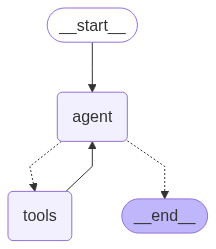

In [107]:
from langgraph.prebuilt import create_react_agent
from IPython.display import Image, display

# 그래프 생성 
answer_reviewer = create_react_agent(
    llm, 
    tools=tools, 
    state_modifier=evaluation_prompt,
    )

# 그래프 출력
display(Image(answer_reviewer.get_graph().draw_mermaid_png()))

In [108]:
# 그래프 실행
from langchain_core.messages import HumanMessage

messages = [HumanMessage(content=f"""[질문]\n\{value['question']}n\n[답변]\n{value['final_answer']}""")]
messages = answer_reviewer.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

[질문]
\택배가 운송 도중 분실되었는데 물품이 분실된 경우에도 택배비를 내야하나요?n
[답변]
택배가 운송 도중 분실된 경우, 물품의 분실에 대한 보상뿐만 아니라 이미 지불한 택배비도 환급받을 수 있으므로, 추가로 택배비를 부담하지 않아도 됩니다 (출처: wisetripguide (https://wisetripguide.com/택배-분실-시-보상받는-절차-정리/)). 환급을 위해서는 택배사에 분실 신고 및 보상 신청을 해야 하며, 각 택배사의 정책을 확인하는 것이 중요합니다 (출처: wisetripguide (https://wisetripguide.com/택배-분실-시-보상받는-절차-정리/)).
================================== Ai Message ==================================

{
  "scores": {
    "accuracy": 8,
    "relevance": 10,
    "completeness": 8,
    "citation_accuracy": 6,
    "clarity_conciseness": 9,
    "objectivity": 9
  },
  "total_score": 50,
  "brief_evaluation": "답변은 질문에 대해 전반적으로 정확하고 관련성이 높으며, 환급 가능성에 대해 잘 설명하고 있습니다. 다만, 인용한 출처가 공식 법령이나 공신력 있는 기관이 아니라 블로그이므로 인용 정확성이 다소 떨어집니다. 또한, 법적 근거(예: 전자상거래법 등)에 대한 직접적인 언급이 없어 완전성과 정확성에서 약간의 감점이 있습니다."
}


In [109]:
json.loads(m.content).keys()

dict_keys(['scores', 'total_score', 'brief_evaluation'])

In [110]:
print(json.loads(m.content)['total_score'])

50


### 4-2. HITL:답변 평가 내용을 확인 

In [112]:
# 답변 평가하는 노드를 추가
def evaluate_answer_node(state:ResearchAgentState):
    question = state["question"]
    final_answer = state["final_answer"]

    messages = [HumanMessage(content=f"""[질문]\n\{question}n\n[답변]\n{final_answer}""")]
    response = answer_reviewer.invoke({"messages": messages})
    response_dict = json.loads(response['messages'][-1].content)

    return {"evaluation_report": response_dict, "question": question, "final_answer": final_answer}

# HITL 조건부 엣지 정의
def human_review(state: ResearchAgentState):
    print("\n현재 답변:")
    print(state['final_answer'])
    print("\n평가 결과:")
    print(f"총점: {state['evaluation_report']['total_score']}/60")
    print(state['evaluation_report']['brief_evaluation'])
    
    user_input = input("\n이 답변을 승인하시겠습니까? (y/n): ").lower()
    
    if user_input == 'y':
        return "approved"
    else:
        return "rejected"
    

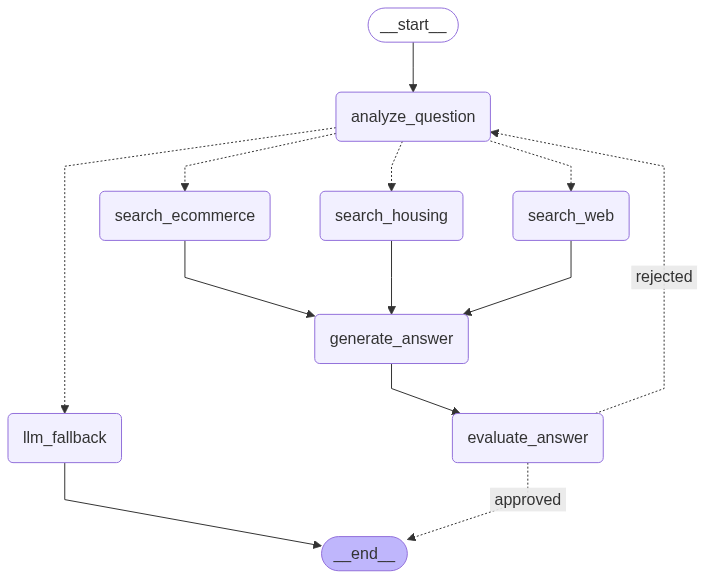

In [113]:
# 노드 정의를 딕셔너리로 관리
nodes = {
    "analyze_question": analyze_question_tool_search,
    "search_ecommerce": ecommerce_rag_node,
    "search_housing": housing_rag_node,
    "search_web": web_rag_node,
    "generate_answer": answer_final,
    "llm_fallback": llm_fallback,
    "evaluate_answer": evaluate_answer_node, 
}

# 그래프 생성을 위한 StateGraph 객체를 정의
search_builder = StateGraph(ResearchAgentState)

# 노드 추가
for node_name, node_func in nodes.items():
    search_builder.add_node(node_name, node_func)

# 엣지 추가 (병렬 처리)
search_builder.add_edge(START, "analyze_question")
search_builder.add_conditional_edges(
    "analyze_question",
    route_datasources_tool_search,
    ["search_ecommerce",  "search_housing", "search_web", "llm_fallback"]
)

# 검색 노드들을 generate_answer에 연결
for node in ["search_ecommerce","search_housing", "search_web"]:
    search_builder.add_edge(node, "generate_answer")

search_builder.add_edge("generate_answer", "evaluate_answer")

# HITL 결과에 따른 조건부 엣지 추가
search_builder.add_conditional_edges(
    "evaluate_answer",
    human_review,
    {
        "approved": END,
        "rejected": "analyze_question"  # 승인되지 않은 경우 질문 분석 단계로 돌아감
    }
)

search_builder.add_edge("llm_fallback", END)

# 그래프 컴파일
legal_rag_agent = search_builder.compile()

# 그래프 시각화 
display(Image(legal_rag_agent.get_graph().draw_mermaid_png()))

In [114]:
inputs = {"question": "안전한 전기매트를 어떻게 선택할 수 있나요?"}
for output in legal_rag_agent.stream(inputs):
    for key, value in output.items():
        # 노드 출력
        pprint(f"Node '{key}':")
        pprint(f"Value: {value}", indent=2, width=80, depth=None)
    print("\n----------------------------------------------------------\n")

"Node 'analyze_question':"
"Value: {'datasources': ['search_web']}"

----------------------------------------------------------

--- 인터넷 검색 전문가 에이전트 시작 ---
---문서 검색---
---정보 추출 및 평가---
---답변 생성---
"Node 'search_web':"
("Value: {'answers': ['1. 질문에 대한 직접적인 답변  \\n안전한 전기매트를 선택하려면 다음과 같은 요소를 종합적으로 "
 '고려해야 합니다.  \\n- KC 인증 마크 등 공식 안전 인증이 있는 제품을 선택하세요.  \\n- 열 효율성, 재질, 크기, 디자인, '
 '가격, 브랜드 등도 함께 확인해야 합니다.  \\n이러한 기준을 충족하는 제품을 선택하면 보다 안전하게 전기매트를 사용할 수 있습니다. '
 '(출처: 한의사닷컴 (https://hanys.kr/전자파-없는-전기매트-구매팁-꼭-확인하세요/), 네이버 블로그 '
 '(https://blog.naver.com/garagehu/223875960730))\\n\\n2. 관련 출처 및 링크  \\n- KC '
 '인증 마크 확인 방법 및 안전성 안내: [한의사닷컴](https://hanys.kr/전자파-없는-전기매트-구매팁-꼭-확인하세요/)  '
 '\\n- 전기매트 선택 시 고려사항: [네이버 '
 '블로그](https://blog.naver.com/garagehu/223875960730)\\n\\n3. 추가 설명 또는 예시  '
 '\\nKC 인증 마크는 대한민국에서 전기제품의 안전성을 보장하는 국가 인증입니다. 제품에 KC 마크가 부착되어 있는지, 제품 설명서나 '
 '포장에 인증번호가 명시되어 있는지 꼭 확인하세요. 또한, 전기매트의 재질이 난연성(불에 잘 타지 않는 소재)인지, 온도 조절 기능이 '
 '정밀한지, 과열 방지 장치가 있는지도 중요한 선택 기준입니다.  \\n예를 들어, "KC 

In [115]:
value

{'question': '안전한 전기매트를 어떻게 선택할 수 있나요?',
 'final_answer': '안전한 전기매트를 선택하려면 KC 인증 등 공식 안전 인증이 있는지 반드시 확인해야 하며, 열 효율성, 재질, 크기, 디자인, 가격, 브랜드 등 다양한 요소를 종합적으로 고려해야 합니다 (출처: 한의사닷컴 (https://hanys.kr/전자파-없는-전기매트-구매팁-꼭-확인하세요/), 네이버 블로그 (https://blog.naver.com/garagehu/223875960730)).  \nKC 인증 마크는 국가에서 전기제품의 안전성을 검증했다는 표시이므로, 제품에 KC 마크가 부착되어 있는지와 인증번호가 명시되어 있는지 꼭 확인해야 합니다. 또한, 난연성(불에 잘 타지 않는 소재) 재질, 정밀한 온도 조절 기능, 과열 방지 장치가 있는지도 중요한 선택 기준입니다 (출처: 한의사닷컴, 네이버 블로그).  \n이러한 기준을 충족하는 제품을 선택하면 보다 안전하게 전기매트를 사용할 수 있습니다 (출처: 한의사닷컴, 네이버 블로그).',
 'evaluation_report': {'scores': {'accuracy': 9,
   'relevance': 10,
   'completeness': 9,
   'citation_accuracy': 8,
   'clarity_conciseness': 9,
   'objectivity': 10},
  'total_score': 55,
  'brief_evaluation': '답변은 안전한 전기매트 선택 기준(인증, 재질, 기능 등)을 구체적으로 안내하고 있어 정확성과 관련성이 높습니다. 인용 출처도 실제로 존재하는 정보원이지만, 공식 기관이나 더 신뢰도 높은 자료 인용이 부족해 인용 정확성에서 약간 감점했습니다. 전반적으로 명확하고 객관적이며, 실질적인 구매 팁을 잘 전달하고 있습니다.'}}

In [116]:
inputs = {"question": "판매자가 물건 반품을 거절하는 경우는 어떻게 해야하죠?"}
for output in legal_rag_agent.stream(inputs):
    for key, value in output.items():
        # 노드 출력
        pprint(f"Node '{key}':")
        pprint(f"Value: {value}", indent=2, width=80, depth=None)
    print("\n----------------------------------------------------------\n")

"Node 'analyze_question':"
"Value: {'datasources': ['search_web']}"

----------------------------------------------------------

--- 인터넷 검색 전문가 에이전트 시작 ---
---문서 검색---
---정보 추출 및 평가---
---답변 생성---
"Node 'search_web':"
("Value: {'answers': ['1. 질문에 대한 직접적인 답변  \\n판매자가 물건 반품을 거절하는 경우, 우선 해당 업체의 "
 '고객센터나 관리자에게 정식으로 항의하는 서면 민원을 제출해야 합니다. 이때 구매내역, 반품 사유, 요구사항을 명확하게 기재하고, 영수증, '
 '주문확인서, 상품 사진 등 증거자료를 첨부하는 것이 중요합니다.  \\n\\n2. 관련 출처 및 링크  \\n- 상품 반품 거부 시 서면 '
 '민원 제기 안내: [Productwise 공식 홈페이지](https://productwise.kr/7917/)  \\n\\n3. 추가 '
 '설명 또는 예시  \\n서면 민원은 이메일, 우편, 또는 업체가 제공하는 공식 문의 양식을 통해 제출할 수 있습니다. 민원서에는 다음과 '
 '같은 내용을 포함해야 합니다:  \\n- 구매내역(주문번호, 구매일자 등)  \\n- 반품을 요청하는 구체적인 사유  \\n- 본인이 '
 '원하는 요구사항(환불, 교환 등)  \\n- 증거자료(영수증, 주문확인서, 상품 사진 등)  \\n이러한 절차를 거친 후에도 해결되지 '
 '않을 경우, 한국소비자원 등 외부 기관에 분쟁 조정을 신청할 수 있습니다.  \\n\\n4. 결론 및 요약  \\n판매자가 반품을 거절할 '
 '경우, 정식 서면 민원을 통해 자신의 권리를 주장하고, 관련 증거자료를 첨부하는 것이 중요합니다. 필요시 외부 기관의 도움을 받을 수 '
 "있습니다. (출처: [Productwise 공식 홈페이지](https://productwise.kr/7917/))

In [117]:
value

{'question': '판매자가 물건 반품을 거절하는 경우는 어떻게 해야하죠?',
 'final_answer': '판매자가 물건 반품을 거절하는 경우, 우선 해당 업체의 고객센터나 관리자에게 정식으로 항의하는 서면 민원을 제출해야 합니다. 이때 구매내역, 반품 사유, 요구사항을 명확하게 기재하고, 영수증, 주문확인서, 상품 사진 등 증거자료를 첨부하는 것이 중요합니다. 서면 민원은 이메일, 우편, 또는 업체가 제공하는 공식 문의 양식을 통해 제출할 수 있습니다. 이러한 절차를 거친 후에도 해결되지 않을 경우, 한국소비자원 등 외부 기관에 분쟁 조정을 신청할 수 있습니다 (출처: [Productwise 공식 홈페이지](https://productwise.kr/7917/)).',
 'evaluation_report': {'scores': {'accuracy': 8,
   'relevance': 9,
   'completeness': 8,
   'citation_accuracy': 5,
   'clarity_conciseness': 9,
   'objectivity': 9},
  'total_score': 48,
  'brief_evaluation': '답변은 반품 거절 시 취할 수 있는 절차를 비교적 정확하고 명확하게 안내하고 있습니다. 다만, 전자상거래법 등 관련 법률적 근거가 직접적으로 언급되지 않았고, 인용한 출처의 신뢰성과 정확성이 다소 부족합니다. 전반적으로 실무적 조언은 적절하나, 법적 근거와 공식 기관 안내가 보강되면 더 완전한 답변이 될 것입니다.'}}

# 5. Gradio 챗봇

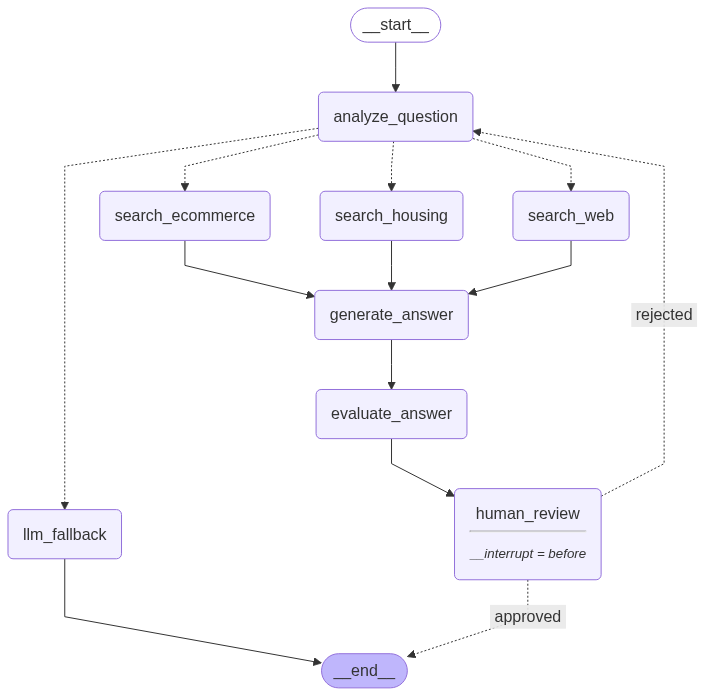

In [119]:
from langgraph.checkpoint.memory import MemorySaver

# HITL 노드로 변경 (그라디오에서 입력을 처리)
def human_review(state: ResearchAgentState):
    pass

# 그래프 생성을 위한 StateGraph 객체를 정의
search_builder = StateGraph(ResearchAgentState)

# 노드 추가
nodes = {
    "analyze_question": analyze_question_tool_search,
    "search_ecommerce": ecommerce_rag_node,
    "search_housing": housing_rag_node,
    "search_web": web_rag_node,
    "generate_answer": answer_final,
    "llm_fallback": llm_fallback,
    "evaluate_answer": evaluate_answer_node, 
    "human_review": human_review,
}

for node_name, node_func in nodes.items():
    search_builder.add_node(node_name, node_func)

# 엣지 추가 (병렬 처리)
search_builder.add_edge(START, "analyze_question")
search_builder.add_conditional_edges(
    "analyze_question",
    route_datasources_tool_search,
    ["search_ecommerce", "search_housing", "search_web", "llm_fallback"]
)

# 검색 노드들을 generate_answer에 연결
for node in ["search_ecommerce", "search_housing", "search_web"]:
    search_builder.add_edge(node, "generate_answer")

search_builder.add_edge("generate_answer", "evaluate_answer")
search_builder.add_edge("evaluate_answer", "human_review")

# HITL 결과에 따른 조건부 엣지 추가
search_builder.add_conditional_edges(
    "human_review",
    lambda x: "approved" if x.get("user_decision") == "approved" else "rejected",
    {
        "approved": END,
        "rejected": "analyze_question"
    }
)

search_builder.add_edge("llm_fallback", END)

# 메모리 추가
memory = MemorySaver()

# 그래프 컴파일 (Breakpoint 설정)
legal_rag_agent = search_builder.compile(checkpointer=memory, interrupt_before=["human_review"])

# 그래프 시각화 
display(Image(legal_rag_agent.get_graph().draw_mermaid_png()))

In [120]:
# import gradio as gr
# import uuid
# from typing import List, Tuple
# from langgraph.checkpoint.memory import MemorySaver

# # 메모리 사용 준비
# memory = MemorySaver()
# legal_rag_agent = search_builder.compile(checkpointer=memory, interrupt_before=["human_review"])

# # 예시 질문들
# example_questions = [
#     "건강기능식품이 뭔가요? 약이랑 다른가요?",
#     "구매한 의류건조기가 해당 제품이 거짓‧과대광고인 경우 어떤 조치가 취해지나요?",
#     "택배기사가 배송 중 물건을 파손했어요. 어떻게 해야 하나요?",
# ]



# # 챗봇 클래스 생성
# class ChatBot:
#     def __init__(self):
#         self.thread_id = str(uuid.uuid4())
#         self.user_decision = False

#     def process_message(self, message: str) -> str:
#         try:
#             config = {"configurable": {"thread_id": self.thread_id}}
            
#             if not self.user_decision:
#                 # Breakpoint 까지 먼저 실행
#                 inputs = {"question": message}
#                 legal_rag_agent.invoke(inputs, config=config)

#                 # Breakpoint에서 현재 상태를 출력하고, 사용자의 승인 여부를 입력받음 
#                 current_state = legal_rag_agent.get_state(config)
#                 print("Current state:", current_state)
                
#                 final_answer = current_state.values.get("final_answer", "No answer available")
#                 evaluation_report = current_state.values.get('evaluation_report', {'total_score': 0, 'brief_evaluation': 'No evaluation available'})
                
#                 response = f"""현재 답변:
#             {final_answer}

#             평가 결과:
#             총점: {evaluation_report.get('total_score', 0)}/60
#             {evaluation_report.get('brief_evaluation', 'No evaluation available')}

#             이 답변을 승인하시겠습니까? (y/n): """
                
#                 # 사용자 승인 여부를 True로 변경 
#                 self.user_decision = True
#                 return response
                
#             else:
#                 # 사용자 입력에 따라 다음 경로를 선택
#                 user_decision = message.lower()
#                 if user_decision == 'y':
#                     self.user_decision = False # 초기화 
#                     # 상태 업데이트 - 질문을 수정하여 업데이트
#                     legal_rag_agent.update_state(config, {"user_decision": "approved"})
#                     # 나머지 작업을 이어서 진행 
#                     legal_rag_agent.invoke(None, config=config)
#                     # 작업이 종료되고 최종 상태의 메시지를 출력 
#                     current_state = legal_rag_agent.get_state(config)
#                     print("Final state:", current_state)
#                     return current_state.values.get("final_answer", "No final answer available")
#                 else:
#                     self.user_decision = False # 초기화 
#                     # 상태 업데이트 - 질문을 수정하여 업데이트
#                     legal_rag_agent.update_state(config, {"user_decision": "rejected"})
#                     # 나머지 작업을 이어서 진행 
#                     legal_rag_agent.invoke(None, config=config)
#                     # Breakpoint에서 현재 상태를 출력하고, 사용자의 승인 여부를 입력받음 
#                     current_state = legal_rag_agent.get_state(config)
#                     print("Revised state:", current_state)
                    
#                     final_answer = current_state.values.get("final_answer", "No answer available")
#                     evaluation_report = current_state.values.get('evaluation_report', {'total_score': 0, 'brief_evaluation': 'No evaluation available'})
                    
#                     response = f"""다시 생성한 답변:
#                 {final_answer}

#                 평가 결과:
#                 총점: {evaluation_report.get('total_score', 0)}/60
#                 {evaluation_report.get('brief_evaluation', 'No evaluation available')}

#                 이 답변을 승인하시겠습니까? (y/n): """
                    
#                     # 사용자 승인 여부를 True로 변경 
#                     self.user_decision = True
#                     return response

#         except Exception as e:
#             print(f"Error occurred: {str(e)}")
#             return "죄송합니다. 응답을 생성하는 동안 오류가 발생했습니다. 다시 시도해 주세요."

#     def chat(self, message: str, history: List[Tuple[str, str]]) -> str:
#         print(f"Thread ID: {self.thread_id}")
#         response = self.process_message(message)
#         return response

# chatbot = ChatBot()

# # ChatInterface 생성
# demo = gr.ChatInterface(
#     fn=chatbot.chat,
#     title="로키비키와 법률 상담",
#     description="생활 법률 고민이 생겼을 때, 24시간 언제든 로키비키 럭키비키한 하루🍀",
#     examples=example_questions,
#     theme=gr.themes.Soft(),
    
# )

# # Gradio 앱 실행
# demo.launch()

Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


Thread ID: 5563502a-c1cc-40d9-b970-b050d6d3e9c0
--- 인터넷 검색 전문가 에이전트 시작 ---
---문서 검색---
---정보 추출 및 평가---
---답변 생성---
---최종 답변---
Current state: StateSnapshot(values={'question': '건강기능식품이 뭔가요? 약이랑 다른가요?', 'answers': ['1. 질문에 대한 직접적인 답변  \n건강기능식품은 인체에 유용한 기능성을 가진 원료나 성분을 사용하여 제조된 식품으로, 건강을 유지하거나 증진하는 데 도움을 줄 수 있습니다. 하지만 건강기능식품은 특정 질병을 치료하거나 예방하는 효과가 없으며, 의약품(약)과는 명확히 구분됩니다. 건강기능식품과 의약품을 혼동해서는 안 되며, 기존에 복용 중인 약이 있다면 건강기능식품과의 상호작용 여부를 반드시 확인해야 합니다. 필요시 약사와 상담하는 것이 좋습니다 (출처: 네이버 블로그(https://m.blog.naver.com/tobecontinue_777/223786520998)).\n\n2. 관련 출처 및 링크  \n- 건강기능식품과 의약품의 차이, 상호작용 주의사항: [네이버 블로그](https://m.blog.naver.com/tobecontinue_777/223786520998)  \n- 건강기능식품 정의 및 정보(공식): [식품의약품안전처 건강기능식품 정보포털](https://www.foodsafetykorea.go.kr/portal/healthyfoodlife/healthyfoodlife.do)\n\n3. 추가 설명 또는 예시  \n예를 들어, 비타민C, 오메가-3, 프로바이오틱스 등은 건강기능식품으로 분류됩니다. 이들은 건강 유지에 도움을 줄 수 있지만, 감기나 고혈압 등 특정 질병을 치료하는 약은 아닙니다. 반면, 감기약, 혈압약 등은 의약품으로, 질병의 치료나 예방을 목적으로 사용됩니다. 건강기능식품을 복용할 때는 기존에 먹고 있는 약과의 상호작용 가능성도 고려해야 하므로, 

In [ ]:
import gradio as gr
import uuid
from typing import List, Tuple

# 예시 질문
# example_questions = [
#     "사업장에서 CCTV를 설치할 때 주의해야 할 법적 사항은 무엇인가요?",
#     "전월세 계약 갱신 요구권의 행사 기간과 조건은 어떻게 되나요?",
#     "개인정보 유출 시 기업이 취해야 할 법적 조치는 무엇인가요?",
#     "번개 장터에서 물건을 샀는데 벽돌이 왔어요. 어떤 조치를 취할 수 있을까요?",
# ]

# 메모리 사용 준비
memory = MemorySaver()
legal_rag_agent = search_builder.compile(checkpointer=memory, interrupt_before=["human_review"])

# 테스트용 목업
# def mock_legal_agent(question: str) -> str:
#     return f"""답변: '{question}'에 대한 답변입니다. 판매자와 연락 후 해결되지 않으면 민사소송이 가능합니다.
# 관련 법령: ["민법 제390조", "형법 제347조", "전자상거래법 제17조"]"""

# 챗봇 클래스 정의
class ChatBot:
    def __init__(self):
        self.thread_id = str(uuid.uuid4())

    def process_message(self, message: str) -> str:
        config = {"configurable": {"thread_id": self.thread_id}}
        try:
            inputs = {"question": message}
            legal_rag_agent.invoke(inputs, config=config)
            current_state = legal_rag_agent.get_state(config)
            final_answer = current_state.values.get("final_answer", "No answer available")
            return final_answer
        except Exception as e:
            return "죄송합니다. 응답을 생성하는 동안 오류가 발생했습니다. 다시 시도해 주세요."
        # return mock_legal_agent(message)  # 테스트 시 목업 함수 사용
        
    def chat(self, message: str, history: List[Tuple[str, str]]) -> str:
        return self.process_message(message)

chatbot = ChatBot()

# 사용자 정의 CSS
custom_css = """
/* 타이틀 영역 */
h1 {
    background: linear-gradient(90deg, #60A5FA, #2563EB);
    color: white !important;
    padding: 1.2rem;
    border-radius: 12px;
    text-align: left;
    font-size: 1.6rem;
}

/* 설명 영역도 동일한 그라데이션 + 중앙 정렬 */
p {
    color: #111827;
    padding: 0.8rem;
    border-radius: 12px;
    text-align: center !important;
    font-weight: 400;
    font-size: 1rem;
    margin-bottom: 1.2rem;
}


/* 사용자 메시지 말풍선 */
.message.user {
    background-color: #E0F2FE !important;
    color: #111827 !important;
    border-radius: 20px 20px 4px 20px;  /* 둥글게 */
    padding: 7px !important;
    font-weight: 500;
    text-align: left !important;

}

/* 챗봇 메시지 말풍선 */
.message.bot {
    background-color: #F3F4F6 !important;
    color: #111827 !important;
    border-radius: 20px 20px 4px 20px;  /* 둥글게 */
    padding: 7px !important;
    font-weight: 500;
    text-align: left !important;

}
"""


# ChatInterface 생성
demo = gr.ChatInterface(
    fn=chatbot.chat,
    title="로키비키와 법률 상담",
    description="생활 법률 고민이 생겼을 때, 24시간 언제든 로키비키와 럭키비키한 하루🍀",
    # examples=example_questions,
    theme=gr.themes.Soft(),
    css=custom_css,
    textbox=gr.Textbox(placeholder="궁금한 법률 문제를 입력해주세요...")
)

# 앱 실행 (로컬에서는 `demo.launch()` 사용)
demo.launch()

In [121]:
# demo.close()

Closing server running on port: 7861
